In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units

In [2]:
n_BHs = 10000
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_BHs = new_powerlaw_mass_distribution(n_BHs, 
                                         10.0|units.MSun, 
                                         100.0|units.MSun, 
                                         alpha_IMF)

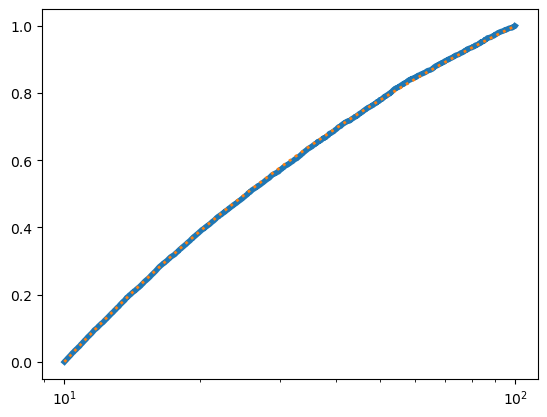

In [3]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun))
    fm = numpy.array([0])
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi)
    fm /= max(fm)
    from amuse.plot import plot
    pyplot.plot(m, fm[:len(m)], lw=4, ls="-")
    x = 10**numpy.arange(1.0, 2.0, 1./len(m))
    y = x**(alpha_IMF+2)
    fy = numpy.array([0])
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi)    
    fy /= max(fy)
    pyplot.plot(x, fy[:len(x)], lw=2, ls=":")
    pyplot.semilogx()
    pyplot.show()
plot_cdf(m_BHs)

In [4]:
r_cluster = 3.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_BHs.sum(), r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 3.0
bodies=new_king_model(n_BHs, W0, convert_nbody=converter)
bodies.mass = m_BHs.in_(units.MSun)
bodies.scale_to_standard(converter)
bodies.move_to_center()

In [5]:
from amuse.lab import Particles
SMBH = Particles(1)
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms

bodies.add_particle(SMBH)

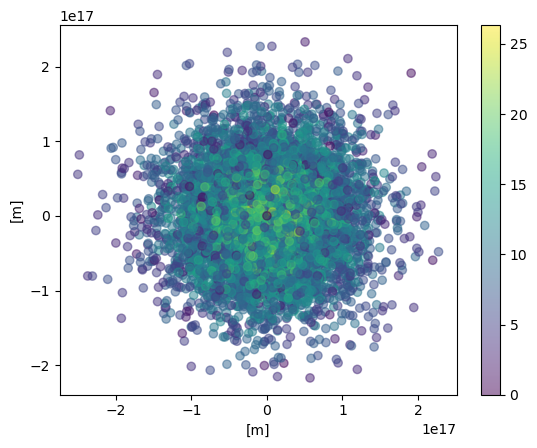

In [6]:
from amuse.plot import scatter
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    scatter(bodies.x.value_in(units.pc), bodies.y.value_in(units.pc), c=v.value_in(units.kms).value_in(units.pc), alpha=0.5)
    pyplot.colorbar()
    pyplot.show()
plot_snapshot(bodies)

In [7]:
from amuse.lab import Hermite

In [8]:
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity = Hermite(converter, number_of_workers=8)
gravity.particles.add_particles(bodies)
# A channel is a 'permanent' connection to a code's particle
# set. Multiple calls to a code's particle set need to set up
# a new connection every time; with a channel, we can copy
# information back without opening a new connection.
# This does not automatically update bodies! See below
channel = gravity.particles.new_channel_to(bodies)


times = numpy.arange(0, 1, 0.01) | units.Myr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.yr)%100.0:
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
        b = bodies[:-1].get_binaries()
        if(len(b)>0):
            print("Number of binaries found:", len(b))
            print("first binary:", b[0])

pyplot.plot(times.value_in(units.Myr), RL25.value_in(units.parsec))
pyplot.plot(times.value_in(units.Myr), Rvir.value_in(units.parsec))
pyplot.show()

cluster at Time= 0.0 Myr Mass= 4378243.2533 MSun Rvir= 19.7576895523 parsec


KeyboardInterrupt: 

In [ ]:
v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
scatter(bodies.x, bodies.y, c=bodies.mass.value_in(units.MSun), vmin=0, vmax=100, alpha=0.5)
pyplot.colorbar()
pyplot.show()